In [1]:
import re
import time
import json
import pickle
import random
import pandas as pd
import seaborn as sns
import networkx as nx
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import community as community_louvain

from wordcloud import WordCloud
from sklearn.cluster import KMeans
from collections import defaultdict, Counter
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from networkx.algorithms.link_prediction import jaccard_coefficient, adamic_adar_index

# Introduction

This study analyzes artist collaboration patterns by constructing a social network graph from a Spotify dataset containing over 114,000 songs. Using network science techniques such as centrality analysis and the Louvain community detection algorithm, the research identifies key influencers within the music collaboration landscape and examines how factors like genre, popularity, and explicit content influence networking behavior. The data underwent rigorous preprocessing, including removal of duplicates, normalization of artist names, standardization of genres, and filtering out irrelevant features to ensure accurate graph construction.

The results reveal that artists tend to collaborate within genre-specific communities, indicating strong genre specialization. Additionally, a noticeable divide exists between artists who produce explicit content and those who do not. Centrality measures helped highlight the most influential artists in the network, while community detection revealed distinct clusters, typically centered around dominant musical genres. The study also investigates assortativity and homophily, showing that artists often collaborate with others who share similar attributes.


#1. Data loading
The analysis is based on a CSV dataset (‘dataset.csv’), which we first loaded and inspected. The dataset contains over 114,000 songs. The pre-processing of the data comprised several steps to ensure the quality for the subsequent network analysis. Firstly, we removed exact duplicates from the data set. Optional, duplicate tracks by the same artist could also be deleted by dropping duplicates based on the columns 'track_name' and 'artists'. To normalise the artist names, we developed a function called parse_artists_final which cleans up artist names and ensures that they are available as lists of lower-case, cleaned-up strings. We also converted string representations of lists correctly and names that were separated by semicolons we split into separate artist entries. This splitting was explicitly applied using a function called split_semicolon_artists. In the next step, we standardized the genres: we filled missing genre entries with ‘unknown’, we converted all genres to lowercase and we removed spaces. Finally, we removed irrelevant columns that were classified as less important for the planned network analysis (such as duration_ms, key, loudness, mode, speechiness, acousticness, instrumentalness, liveness, valence, tempo, time_signature). We displayed the remaining columns for checking.


In [2]:
# Load dataset
df = pd.read_csv('dataset.csv')

# Initial inspection
print(df.shape)
df.head()


(114000, 21)


,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,...,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,...,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,...,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,...,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,...,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


# **Preprocessing**

In [3]:
# Remove exact duplicates
df = df.drop_duplicates()

# Drop duplicate track names by same artist
df = df.drop_duplicates(subset=['track_name', 'artists'])


In [4]:
def parse_artists_final(x):
    # If it's already a list, return as is
    if isinstance(x, list):
        return [a.lower().strip() for a in x]

    # If it's a string, try parsing
    if isinstance(x, str):
        try:
            # Convert single quotes to double quotes for JSON parsing
            val = json.loads(x.replace("'", '"'))
            if isinstance(val, list):
                return [a.lower().strip() for a in val]
            else:
                return [str(val).lower().strip()]
        except (json.JSONDecodeError, TypeError):
            return [x.lower().strip()]

    # Catch-all fallback
    return [str(x).lower().strip()]

# Apply the fix
df['artists'] = df['artists'].apply(parse_artists_final)


In [5]:
df['artists'].head(5)

,artists
0,[gen hoshino]
1,[ben woodward]
2,[ingrid michaelson;zayn]
3,[kina grannis]
4,[chord overstreet]


In [6]:
# Split any entries containing ';' into separate names
def split_semicolon_artists(artist_list):
    split_list = []
    for artist in artist_list:
        split_list.extend([a.strip() for a in artist.split(';')])
    return split_list

# Apply fix
df['artists'] = df['artists'].apply(split_semicolon_artists)


In [7]:
df['artists'].head(5)

,artists
0,[gen hoshino]
1,[ben woodward]
2,"[ingrid michaelson, zayn]"
3,[kina grannis]
4,[chord overstreet]


In [8]:
# Fill missing genres with "unknown"
df['track_genre'] = df['track_genre'].fillna('unknown')

# Standardize genre to lowercase
df['track_genre'] = df['track_genre'].str.strip().str.lower()


In [9]:
# List of columns to remove
columns_to_drop = ['duration_ms', 'key', 'loudness', 'mode',
                   'speechiness', 'acousticness', 'instrumentalness',
                   'liveness', 'valence', 'tempo', 'time_signature']

# Drop the columns (inplace=True modifies the original DataFrame)
df.drop(columns=columns_to_drop, inplace=True)

# Verify the remaining columns
print(df.head())

   Unnamed: 0                track_id                    artists  \
0           0  5SuOikwiRyPMVoIQDJUgSV              [gen hoshino]   
1           1  4qPNDBW1i3p13qLCt0Ki3A             [ben woodward]   
2           2  1iJBSr7s7jYXzM8EGcbK5b  [ingrid michaelson, zayn]   
3           3  6lfxq3CG4xtTiEg7opyCyx             [kina grannis]   
4           4  5vjLSffimiIP26QG5WcN2K         [chord overstreet]   

                                          album_name  \
0                                             Comedy   
1                                   Ghost (Acoustic)   
2                                     To Begin Again   
3  Crazy Rich Asians (Original Motion Picture Sou...   
4                                            Hold On   

                   track_name  popularity  explicit  danceability  energy  \
0                      Comedy          73     False         0.676  0.4610   
1            Ghost - Acoustic          55     False         0.420  0.1660   
2              To Begin

# 2. Synthetic Model Graphs

At the beginning, the code chooses a smaller version of a real graph called G_real (for example, a subgraph or an evaluation set) to avoid performance issues when working with very large datasets. The rest of the code is built around this graph and compares it with synthetic graphs that are generated to mimic it in size.

It defines two helper functions:

One function draws the degree distribution of a graph, which shows how many nodes have a certain number of connections. This helps in understanding whether the graph has a few highly connected hubs or if most nodes have similar degrees.
The second function prints key graph statistics, such as the number of nodes and edges, the average clustering coefficient (how tightly grouped a node's neighbors are), and the average shortest path length (how many steps it takes to get from one node to another on average).
The code then uses the size of the real graph (number of nodes and average number of edges per node) to generate three different types of synthetic graphs:

Barabási-Albert (BA): This model grows a network by attaching new nodes preferentially to existing high-degree nodes, simulating the "rich-get-richer" effect.

Watts-Strogatz (WS): This model starts with a regular ring lattice and randomly rewires some edges to introduce short-cuts, simulating small-world networks that are both clustered and have short paths.

Erdős-Rényi (ER): This model randomly connects pairs of nodes with a given probability, producing a purely random graph.
Next, it visualizes and compares the degree distributions of the real graph and the three model graphs. It plots these distributions on a log-log scale, which helps highlight patterns like power-law behavior or randomness in connectivity. Each model's degree curve is shown in a different color so they can be compared visually.

Finally, the code prints out a summary of the structural characteristics of each graph. This allows you to compare how well the synthetic graphs replicate the real graph in terms of connectivity, clustering, and how easily information might flow through the network.

In [10]:
# Initialize empty graph
G = nx.Graph()

# Build graph edges
for _, row in df.iterrows():
    artists = row['artists']

    # Add edges for collaborations
    if len(artists) > 1:
        for i in range(len(artists)):
            for j in range(i+1, len(artists)):
                a1, a2 = artists[i], artists[j]

                # If the edge already exists, increase the weight
                if G.has_edge(a1, a2):
                    G[a1][a2]['weight'] += 1
                else:
                    G.add_edge(a1, a2, weight=1)

    # Add nodes (even if solo artist)
    for artist in artists:
        if not G.has_node(artist):
            G.add_node(artist)

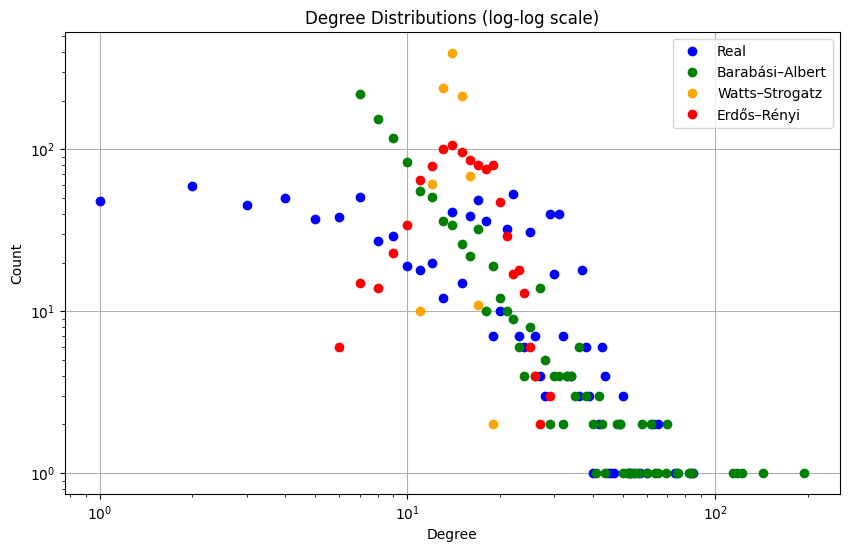


Stats for Real:
Nodes: 1000, Edges: 7650
Average Clustering Coefficient: 0.5948
Average Shortest Path Length: inf

Stats for Barabási–Albert:
Nodes: 1000, Edges: 6951
Average Clustering Coefficient: 0.0482
Average Shortest Path Length: 2.7329

Stats for Watts–Strogatz:
Nodes: 1000, Edges: 7000
Average Clustering Coefficient: 0.5148
Average Shortest Path Length: 3.7527

Stats for Erdős–Rényi:
Nodes: 1000, Edges: 7684
Average Clustering Coefficient: 0.0150
Average Shortest Path Length: 2.8035


In [11]:
# Get top 1000 nodes by degree
top_nodes = sorted(G.degree, key=lambda x: x[1], reverse=True)[:1000]
sub_nodes = [node for node, deg in top_nodes]
G_top_1000 = G.subgraph(sub_nodes).copy()

G_real = G_top_1000

def plot_degree_distribution(G, label, color):
    degree_sequence = sorted([d for n, d in G.degree()], reverse=True)
    degree_count = Counter(degree_sequence)
    deg, cnt = zip(*degree_count.items())
    plt.plot(deg, cnt, marker='o', linestyle='', label=label, color=color)

def print_graph_stats(G, name):
    avg_clustering = nx.average_clustering(G)
    try:
        avg_path = nx.average_shortest_path_length(G)
    except nx.NetworkXError:
        avg_path = float('inf')  # Graph not connected
    print(f"\nStats for {name}:")
    print(f"Nodes: {G.number_of_nodes()}, Edges: {G.number_of_edges()}")
    print(f"Average Clustering Coefficient: {avg_clustering:.4f}")
    print(f"Average Shortest Path Length: {avg_path:.4f}")

# Generate synthetic model graphs
n = G_real.number_of_nodes()
m = int(G_real.number_of_edges() / G_real.number_of_nodes())

# 1. Barabási–Albert (BA)
G_ba = nx.barabasi_albert_graph(n, m)

# 2. Watts–Strogatz (WS)
G_ws = nx.watts_strogatz_graph(n, k=2*m, p=0.1)

# 3. Erdős–Rényi (ER)
p_er = G_real.number_of_edges() / (n * (n - 1) / 2)
G_er = nx.erdos_renyi_graph(n, p_er)

# Compare Degree Distributions
plt.figure(figsize=(10, 6))
plot_degree_distribution(G_real, "Real", "blue")
plot_degree_distribution(G_ba, "Barabási–Albert", "green")
plot_degree_distribution(G_ws, "Watts–Strogatz", "orange")
plot_degree_distribution(G_er, "Erdős–Rényi", "red")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Degree")
plt.ylabel("Count")
plt.title("Degree Distributions (log-log scale)")
plt.legend()
plt.grid(True)
plt.show()

# Print structural stats
print_graph_stats(G_real, "Real")
print_graph_stats(G_ba, "Barabási–Albert")
print_graph_stats(G_ws, "Watts–Strogatz")
print_graph_stats(G_er, "Erdős–Rényi")

This code compares the real artist collaboration graph to three synthetic network models (Barabási-Albert, Watts-Strogatz, and Erdős-Rényi) by visualizing and printing their degree distributions and structural statistics.
which helps in understand how the real artist network differs from popular synthetic graph models in terms of:

- Degree distribution
- Clustering coefficient
- Shortest path length

#### While synthetic graphs are useful for controlled experiments, they fail to capture the complexity of real-world networks.

The real Spotify artist collaboration dataset already contains:

- Actual collaboration patterns
- Genre-based clustering
- Varying artist popularity
- Cultural or industry-driven structures

Synthetic models ignore all of this. They simplify networks to theoretical topologies that lack real-world constraints, leading to misleading results if used for analysis or prediction. Therefore, we focus directly on the real graph, which provides the most accurate insights into structure, dynamics, and recommendation potential.

# 3. Network exploration

## Data visualization

We decided to plot the first 3000 most connected nodes by degree to be able to get a grasp of our dataset.

In [12]:
print(f"Number of artists (nodes): {G.number_of_nodes()}")
print(f"Number of collaborations (edges): {G.number_of_edges()}")

# Show a few edges with weights
for u, v, d in list(G.edges(data=True))[:5]:
    print(f"{u} ↔ {v} | collaborations: {d['weight']}")


Number of artists (nodes): 29812
Number of collaborations (edges): 38677
ingrid michaelson ↔ zayn | collaborations: 1
ingrid michaelson ↔ ajr | collaborations: 1
ingrid michaelson ↔ a great big world | collaborations: 1
ingrid michaelson ↔ cody | collaborations: 1
ingrid michaelson ↔ heart | collaborations: 1


In [13]:
# Top 10 most connected artists
degree_dict = dict(G.degree())
top_artists = sorted(degree_dict.items(), key=lambda x: x[1], reverse=True)[:10]
print("Top 10 most collaborative artists:")
for artist, degree in top_artists:
    print(f"{artist}: {degree} connections")


Top 10 most collaborative artists:
pritam: 177 connections
wolfgang amadeus mozart: 165 connections
giuseppe verdi: 146 connections
arijit singh: 130 connections
yuvan shankar raja: 115 connections
shreya ghoshal: 107 connections
illenium: 96 connections
neha kakkar: 95 connections
giacomo puccini: 89 connections
traditional: 84 connections


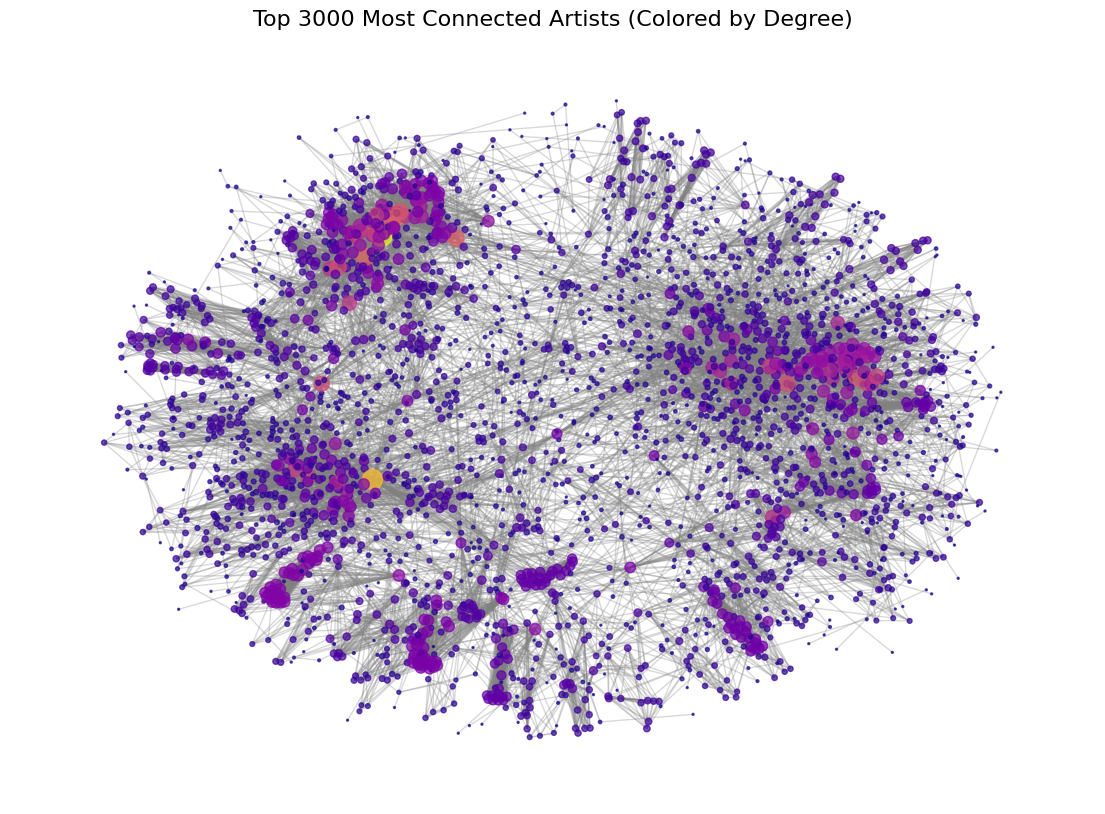

In [14]:
# Subgraph of top 3000 most connected artists
top_artists = sorted(G.degree(), key=lambda x: x[1], reverse=True)[:3000]
subgraph = G.subgraph([n for n, d in top_artists])

# Compute layout (force-directed)
pos = nx.spring_layout(subgraph, seed=42, k=0.15)  # k controls node spacing

# Get node degrees for color mapping
degrees = dict(subgraph.degree())
node_colors = [degrees[n] for n in subgraph.nodes()]

# Normalize node sizes (optional)
node_sizes = [degrees[n]*2 for n in subgraph.nodes()]

# Plot
plt.figure(figsize=(14, 10))
nx.draw_networkx_nodes(subgraph, pos,
                       node_size=node_sizes,
                       node_color=node_colors,
                       cmap=plt.cm.plasma,
                       alpha=0.7)
nx.draw_networkx_edges(subgraph, pos, alpha=0.3, edge_color='gray')
plt.title('Top 3000 Most Connected Artists (Colored by Degree)', fontsize=16)
plt.axis('off')
plt.show()

This graph shows the top 3000 most connected artists in the network, where node size and color reflect how connected each artist is—larger, warmer-colored nodes represent artists with more collaborations or influence. The layout reveals distinct clusters that likely correspond to genre-based or regional communities, with some highly connected artists acting as central hubs or bridges between groups. The structure highlights both densely connected subgroups and more isolated individuals, making it easier to identify key figures and patterns in the artist network.

# Graph Centralities
1. **Degree centrality** - measures how many direct connections a node has in a network. It is useful for identifying the most connected or influential nodes. It is calculated as the number of edges connected to a node divided by the maximum possible connections.

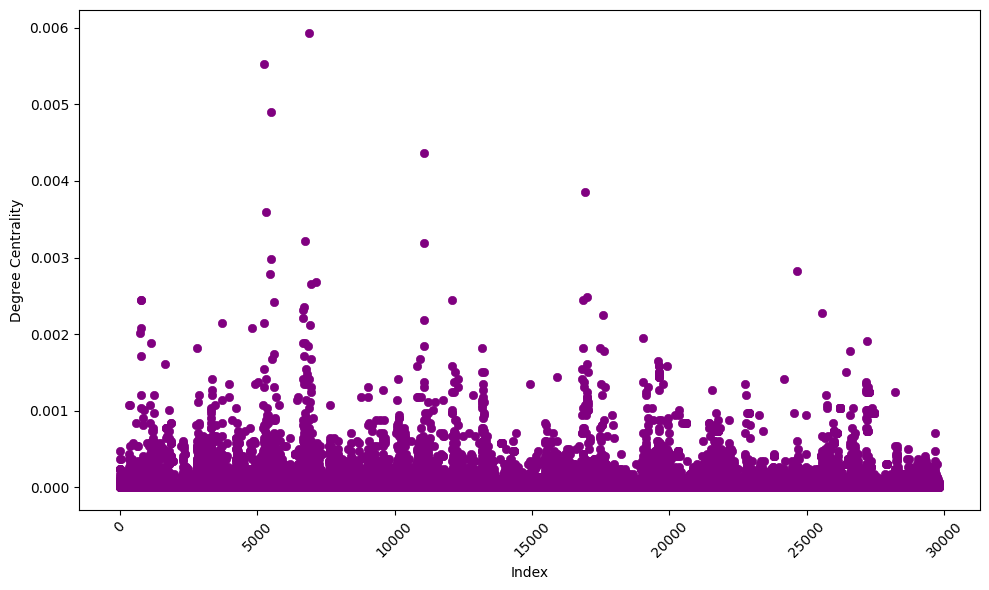

In [15]:
degree_centrality_g = nx.degree_centrality(G)
# Convert to DataFrame
df_deg = pd.DataFrame({
    'Index': range(len(degree_centrality_g)),
    'Degree Centrality': list(degree_centrality_g.values())
})


# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_deg, x='Index', y='Degree Centrality', color='purple', edgecolor='purple')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The distribution is indicating that most nodes have very low centrality while only a few act as minor hubs connected to many others. A small set of outliers with higher centrality may represent key influencers or connectors. The graph is sparse, with a near-zero density and low average degree, suggesting many loosely connected or disconnected components.

2. **Betweenness centrality** - quantifies how often a node appears on the shortest paths between other nodes. It is useful for finding nodes that act as bridges. It is calculated by computing all shortest paths and counting how many pass through each node.
3. **PageRank** - evaluates the importance of nodes based on the number and quality of links to them. It is widely used in web search algorithms. It is calculated iteratively, where a node's score depends on the scores of nodes linking to it, normalized by their number of links (edges).



In [16]:
# Get top 1000 nodes by degree
top_nodes = sorted(G.degree, key=lambda x: x[1], reverse=True)[:1000]
sub_nodes = [node for node, deg in top_nodes]
G_sub = G.subgraph(sub_nodes).copy()

# Degree Centrality
degree_centrality = nx.degree_centrality(G)

# betweenes centrality
btw_cent = nx.betweenness_centrality(G_sub, normalized=True)

# page rank
pr_cent = nx.pagerank(G_sub, alpha=0.85)

# Combine into one DataFrame
centralities_df = pd.DataFrame({
    'artist': list(G_sub.nodes()),
    'pagerank': [pr_cent[node] for node in G_sub.nodes()],
    'betweenness': [btw_cent[node] for node in G_sub.nodes()],
    'degree': [G_sub.degree(node) for node in G_sub.nodes()]
})

# Sort by pagerank (you can change to 'betweenness' or 'degree' if preferred)
top_artists = centralities_df.sort_values(by='pagerank', ascending=False).head(10)
print("Top influential artists by PageRank:")
print(top_artists)


Top influential artists by PageRank:
                artist  pagerank  betweenness  degree
43              pritam  0.009971     0.041209      85
91        arijit singh  0.007649     0.017609      83
717           j balvin  0.005410     0.107087      42
415     giuseppe verdi  0.005215     0.043416      50
284    giacomo puccini  0.004309     0.014519      26
719           deekline  0.004089     0.004762      11
855  luciano pavarotti  0.004047     0.002420      27
254       david guetta  0.004017     0.054708      29
12      shreya ghoshal  0.003621     0.010234      63
452           dj snake  0.003480     0.031530      30


Nodes with high PageRank are influential not just because of their connections, but also because they're connected to other important artists. High Betweenness artists serve as bridges between different parts of the artist collaboration network, while the degree centrality simply shows who collaborates the most.

# K-means
We use the K-Means clustering algorithm to categorize and visualize songs based on their popularity and danceability. The x-axis represents the popularity score of each song, while the y-axis depicts its danceability score.

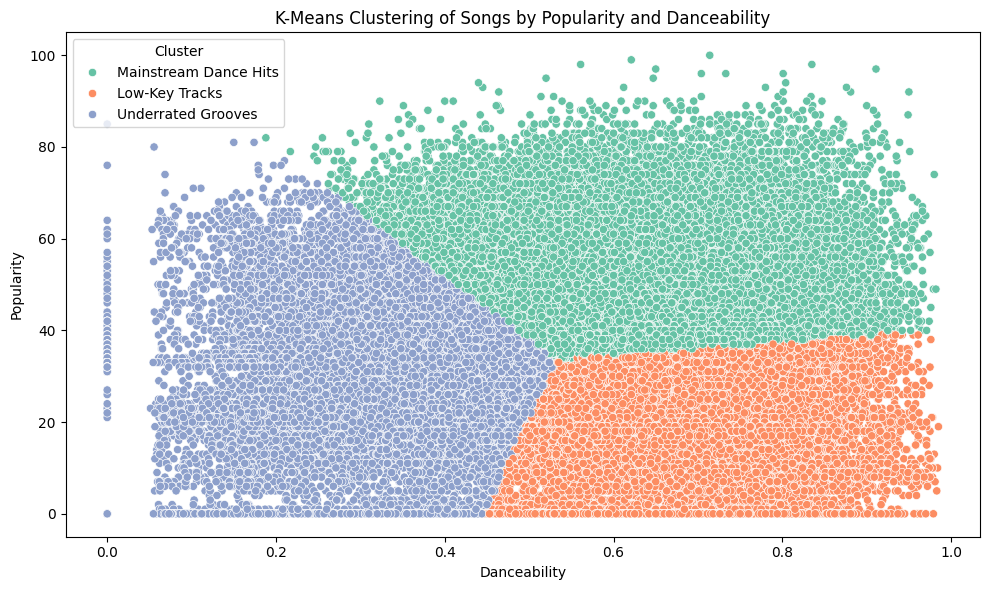

In [17]:
features = df[['popularity', 'danceability']].dropna()

# Normalize (standardize) the features for better clustering
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(scaled_features)

# Add cluster labels back to the DataFrame
df_clustered = features.copy()
df_clustered['Cluster'] = clusters

# Map cluster labels
cluster_labels = {
    0: "Mainstream Dance Hits",
    1: "Underrated Grooves",
    2: "Low-Key Tracks"
}

df_clustered['Cluster'] = df_clustered['Cluster'].map(cluster_labels)

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_clustered,
    x='danceability',
    y='popularity',
    hue='Cluster',
    palette='Set2'
)
plt.title('K-Means Clustering of Songs by Popularity and Danceability')
plt.xlabel('Danceability')
plt.ylabel('Popularity')
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()

The K-Means clustering plot reveals three distinct groups of songs based on their popularity and danceability. One cluster represents highly danceable and popular songs, suggesting mainstream appeal with strong rhythmic qualities. Another cluster includes songs that are highly danceable but less popular, possibly niche or emerging tracks. The third group consists of less danceable and less popular songs, likely representing more subdued or alternative music styles. The clear separation between clusters indicates that danceability and popularity are strong differentiators among tracks.

## 4. Network Analytics


### 4.1 Louvain Alghorithm

The Louvain method we implemented is based on the classic community detection algorithm which optimizes modularity through iterative local node movement and graph aggregation. The algorithm operates in two phases: first, iteratively tries to move each node to a neighboring community if that results in a modularity gain, and second, it creates a new graph where each community becomes a supernode. The edges between communities are the sum of all edges between nodes in those communities.


In [18]:
def louvain_with_aggregation(G):
    def modularity(G, partition):
        m = G.size(weight='weight')
        degrees = dict(G.degree(weight='weight'))
        q = 0
        for comm in set(partition.values()):
            nodes = [n for n in partition if partition[n] == comm]
            for i in nodes:
                for j in nodes:
                    A_ij = G[i][j]['weight'] if G.has_edge(i, j) else 0
                    q += A_ij - degrees[i] * degrees[j] / (2 * m)
        return q / (2 * m)

    def phase_one(G, partition):
        changed = True
        while changed:
            changed = False
            for node in G.nodes():
                best_comm = partition[node]
                best_gain = 0
                current_comm = partition[node]
                community_connections = defaultdict(float)
                for neighbor in G[node]:
                    comm = partition[neighbor]
                    community_connections[comm] += G[node][neighbor].get('weight', 1)
                for comm, total_weight in community_connections.items():
                    if comm != current_comm:
                        old_mod = modularity(G, partition)
                        partition[node] = comm
                        new_mod = modularity(G, partition)
                        gain = new_mod - old_mod
                        if gain > best_gain:
                            best_gain = gain
                            best_comm = comm
                        partition[node] = current_comm  # revert
                if best_comm != current_comm:
                    partition[node] = best_comm
                    changed = True
        return partition

    def aggregate_graph(G, partition):
        new_G = nx.Graph()
        comm_map = defaultdict(list)
        for node, comm in partition.items():
            comm_map[comm].append(node)

        for comm in comm_map:
            new_G.add_node(comm)

        for comm_i, nodes_i in comm_map.items():
            for comm_j, nodes_j in comm_map.items():
                weight = 0
                for u in nodes_i:
                    for v in nodes_j:
                        if G.has_edge(u, v):
                            weight += G[u][v].get('weight', 1)
                if weight > 0:
                    new_G.add_edge(comm_i, comm_j, weight=weight)
        return new_G, comm_map

    G_current = G.copy()
    partition_history = {node: node for node in G.nodes()}
    current_partition = {node: i for i, node in enumerate(G.nodes())}
    start = time.time()

    while True:
        current_partition = phase_one(G_current, current_partition)
        G_current, comm_map = aggregate_graph(G_current, current_partition)

        # Update full partition map
        new_partition = {}
        for comm_id, members in comm_map.items():
            for member in members:
                for original_node in partition_history:
                    if partition_history[original_node] == member:
                        new_partition[original_node] = comm_id
        if current_partition == {n: i for i, n in enumerate(G_current.nodes())}:
            break
        partition_history = new_partition.copy()
        current_partition = {node: i for i, node in enumerate(G_current.nodes())}

    end = time.time()
    final_partition = partition_history
    mod = modularity(G, final_partition)
    return final_partition, mod, end - start


####Benchmarking
We benchmarked our implementation of the Louvain method against the standard version from the Python library.

In [19]:
def benchmark_louvain(G, sizes):
    results = []

    for size in sizes:
        top_nodes = sorted(G.degree, key=lambda x: x[1], reverse=True)[:size]
        sub_nodes = [node for node, deg in top_nodes]
        G_bench = G.subgraph(sub_nodes).copy()

        print(f"\nRunning tests for {size} nodes...")

        # Our implementation
        try:
            start = time.time()
            partition_orig, mod_orig, _ = louvain_with_aggregation(G_bench)
            time_orig = time.time() - start
            with open(f"custom_louvain_top{size}.pkl", "wb") as f:
                pickle.dump((partition_orig, mod_orig, time_orig), f)
        except Exception as e:
            print(f"Original failed for {size} nodes: {e}")
            mod_orig, time_orig = float('nan'), float('nan')

        # Standard implementation
        try:
            start = time.time()
            partition_std = community_louvain.best_partition(G_bench)
            mod_std = community_louvain.modularity(partition_std, G_bench)
            time_std = time.time() - start
        except Exception as e:
            print(f"Standard failed for {size} nodes: {e}")
            mod_std, time_std = float('nan'), float('nan')

        results.append({
            'nodes': size,
            'original_mod': mod_orig,
            'original_time': time_orig,
            'standard_mod': mod_std,
            'standard_time': time_std
        })

        print(f"Size {size}:")
        print(f"  Original: mod={mod_orig:.4f}, time={time_orig:.2f}s")
        print(f"  Standard: mod={mod_std:.4f}, time={time_std:.2f}s")

    return pd.DataFrame(results)

In [20]:
# Define test sizes
# Uncomment this ↓ to run the louvain algorithm for different graph sizes
test_sizes = [10, 50, 100, 250, 300, 500, 750, 1000]

## Run benchmarks
results_df = benchmark_louvain(G, test_sizes)

## Save to CSV
results_df.to_csv('louvain_benchmark_results.csv', index=False)

results_df = pd.read_csv('louvain_benchmark_results.csv')


Running tests for 10 nodes...
Size 10:
  Original: mod=0.0034, time=0.00s
  Standard: mod=0.0000, time=0.00s

Running tests for 50 nodes...
Size 50:
  Original: mod=0.5221, time=0.46s
  Standard: mod=0.5203, time=0.01s

Running tests for 100 nodes...
Size 100:
  Original: mod=0.6409, time=2.89s
  Standard: mod=0.6461, time=0.01s

Running tests for 250 nodes...
Size 250:
  Original: mod=0.7730, time=37.61s
  Standard: mod=0.7730, time=0.03s

Running tests for 300 nodes...
Size 300:
  Original: mod=0.7896, time=64.06s
  Standard: mod=0.7896, time=0.05s

Running tests for 500 nodes...
Size 500:
  Original: mod=0.8196, time=228.91s
  Standard: mod=0.8268, time=0.07s

Running tests for 750 nodes...
Size 750:
  Original: mod=0.8614, time=578.93s
  Standard: mod=0.8640, time=0.12s

Running tests for 1000 nodes...
Size 1000:
  Original: mod=0.8685, time=1752.90s
  Standard: mod=0.8743, time=0.17s


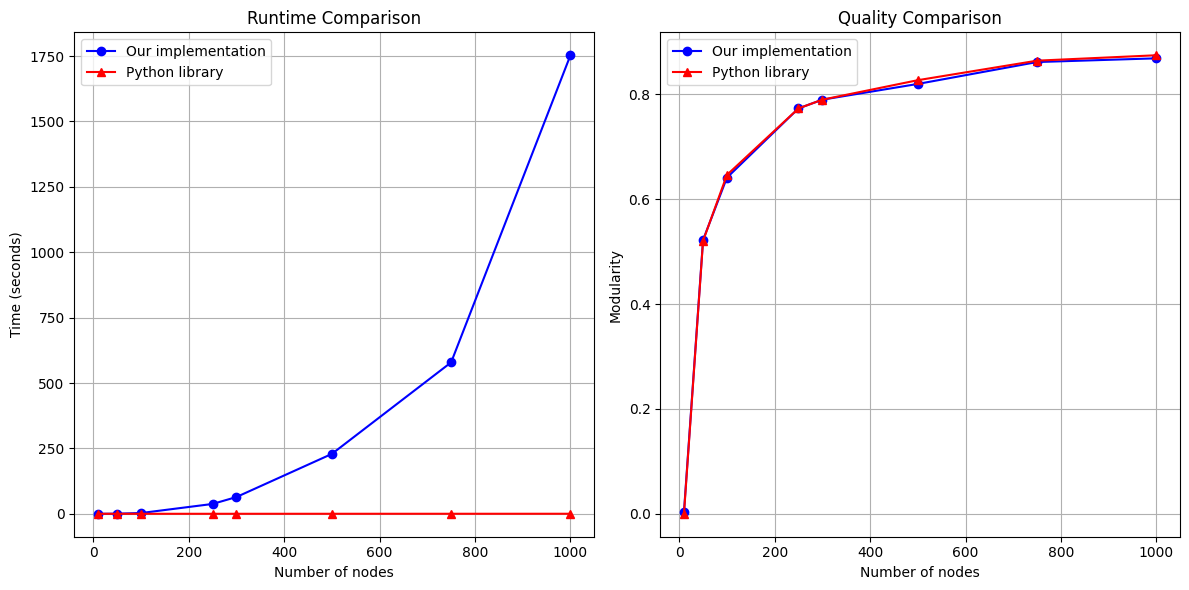

In [21]:
# Plot results
plt.figure(figsize=(12, 6))

# Time comparison
plt.subplot(1, 2, 1)
plt.plot(results_df['nodes'], results_df['original_time'], 'b-o', label='Our implementation')
plt.plot(results_df['nodes'], results_df['standard_time'], 'r-^', label='Python library')
plt.xlabel('Number of nodes')
plt.ylabel('Time (seconds)')
plt.title('Runtime Comparison')
plt.legend()
plt.grid(True)

# Modularity comparison
plt.subplot(1, 2, 2)
plt.plot(results_df['nodes'], results_df['original_mod'], 'b-o', label='Our implementation')
plt.plot(results_df['nodes'], results_df['standard_mod'], 'r-^', label='Python library')
plt.xlabel('Number of nodes')
plt.ylabel('Modularity')
plt.title('Quality Comparison')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('louvain_comparison.png')
plt.show()

Our implementation achieves comparable modularity to the standard python-louvain library but runs significantly slower, indicating room for optimization in modularity computation or graph traversal. Introducing a max_iterations parameter could help balance runtime and correctness, especially for large graphs. Early stopping when modularity gains become negligible could further improve efficiency.

This exercise is valuable to understand how Louvain works internally and why libraries use optimized data structures and approximations.

### 4.2 Community detection

In this part we analyze the relationship between artist communities (detected via our implementation of the Louvain Algorithm) and their musical genres. First, we attach community IDs to each artist node in the graph. Then we build an artist-to-genre mapping from the original dataset and group artists by their detected communities and count genre occurrences within each community. We identifie both the largest communities (by artist count) and the most genre-specialized communities (where one genre dominates). Finally, we print the top 5 largest communities showing their genre distributions, followed by the 3 most genre-concentrated communities with their dominant genre percentages. The output reveals how musical genres cluster within the artist collaboration network, highlighting both diverse and specialized communities. The percentage values show how strongly particular genres characterize each community.


In [22]:
# Get top 1000 nodes by degree
top_nodes = sorted(G.degree, key=lambda x: x[1], reverse=True)[:1000]
sub_nodes = [node for node, deg in top_nodes]
G_top_1000 = G.subgraph(sub_nodes).copy()

In [23]:
# Run custom implementation
# Uncomment this ↓ to run the louvain algorithm for top 1000 nodes
#partition_custom, mod_custom, time_custom = louvain_with_aggregation(G_top_1000)

## Save the outputs to a file
#with open("custom_louvain_top1000.pkl", "wb") as f:
#    pickle.dump((partition_custom, mod_custom, time_custom), f)

In [24]:
# Load the outputs from the file
with open("custom_louvain_top1000.pkl", "rb") as f:
    partition_custom, mod_custom, time_custom = pickle.load(f)

In [25]:
# Attach community ID to each node as an attribute
nx.set_node_attributes(G_top_1000, partition_custom, 'community')

# First, create a mapping from artist to genre
artist_genre_map = {}
for _, row in df.iterrows():
    for artist in row['artists']:
        artist_genre_map[artist.strip().lower()] = row['track_genre']

# Group artists by their community
community_artists = defaultdict(list)
for artist, community in partition_custom.items():
    community_artists[community].append(artist)

# Count genres in each community
community_genre_distribution = {}
for community, artists in community_artists.items():
    genres = [artist_genre_map.get(artist.lower(), 'Unknown') for artist in artists]
    genre_counts = Counter(genres)
    community_genre_distribution[community] = genre_counts

In [26]:
# Get community sizes and sort by size
community_sizes = {comm: len(artists) for comm, artists in community_artists.items()}
top_communities = sorted(community_sizes.items(), key=lambda x: x[1], reverse=True)

# Print top 5 largest communities with their genre distributions
print("\nTop 5 Largest Communities:")
for comm_id, size in top_communities[:5]:
    genre_count = community_genre_distribution[comm_id]
    print(f"\nCommunity {comm_id} (Size: {size} artists)")
    print("Top 5 Genres:")
    for genre, count in genre_count.most_common(5):
        print(f"  {genre}: {count} ({count/size:.1%})")

# Print most genre-concentrated communities (highest % of dominant genre)
genre_concentration = []
for comm_id, genre_count in community_genre_distribution.items():
    total = sum(genre_count.values())
    if total > 0:
        top_genre, top_count = genre_count.most_common(1)[0]
        genre_concentration.append((comm_id, top_genre, top_count/total))

# Filter communities with >90% concentration
high_concentration = [
    (comm_id, genre, conc)
    for comm_id, genre, conc in genre_concentration
    if conc > 0.9  # 90% threshold
]

print("\nMost Genre-Concentrated Communities (Sorted by Size - Largest First):")

for comm_id, genre, concentration in sorted(high_concentration, key=lambda x: (-community_sizes[x[0]], -x[2]))[:3]:
    size = community_sizes[comm_id]
    print(f"\nCommunity {comm_id} (Size: {size})")
    print(f"Dominant Genre: {genre} ({concentration:.1%})")



Top 5 Largest Communities:

Community 0 (Size: 163 artists)
Top 5 Genres:
  progressive-house: 29 (17.8%)
  trance: 20 (12.3%)
  reggae: 13 (8.0%)
  latino: 12 (7.4%)
  trip-hop: 7 (4.3%)

Community 7 (Size: 89 artists)
Top 5 Genres:
  pop-film: 49 (55.1%)
  pop: 29 (32.6%)
  singer-songwriter: 4 (4.5%)
  indian: 2 (2.2%)
  indie: 1 (1.1%)

Community 2 (Size: 63 artists)
Top 5 Genres:
  spanish: 59 (93.7%)
  techno: 2 (3.2%)
  synth-pop: 1 (1.6%)
  latin: 1 (1.6%)

Community 17 (Size: 57 artists)
Top 5 Genres:
  opera: 35 (61.4%)
  sleep: 9 (15.8%)
  classical: 5 (8.8%)
  german: 3 (5.3%)
  tango: 3 (5.3%)

Community 14 (Size: 52 artists)
Top 5 Genres:
  funk: 41 (78.8%)
  pagode: 4 (7.7%)
  mpb: 2 (3.8%)
  reggae: 1 (1.9%)
  brazil: 1 (1.9%)

Most Genre-Concentrated Communities (Sorted by Size - Largest First):

Community 2 (Size: 63)
Dominant Genre: spanish (93.7%)

Community 6 (Size: 32)
Dominant Genre: show-tunes (100.0%)

Community 4 (Size: 30)
Dominant Genre: spanish (100.0%)


This analysis uncovers clear genre-based clustering among artists, highlighting both diverse and highly specialized musical communities. The largest group is rooted in electronic genres like progressive-house and trance, suggesting a broad collaborative space within electronic music. A strong pop-film community in Group 0 reflects a commercially oriented cluster tied to cinematic and mainstream pop production. Other communities show remarkable genre purity, such as the Spanish-dominated Community 5 and an opera-focused cluster, indicating culturally tight-knit artist networks.

Some smaller groups, like those devoted entirely to show-tunes or Spanish music, exhibit complete genre homogeneity, pointing to strong intra-genre collaboration.

These results highlight both the diversity of musical collaborations and the existence of genre-specific artist networks within the broader music ecosystem. The 100% genre concentration in several communities suggests either algorithmic clustering of very similar artists or potentially authentic genre purist collaborations in these musical domains.

### 4.3 Assortativity & Homophily

Assortativity measures the tendency for nodes to connect with similar others, ranging from -1 (perfect disassortment) to 1 (perfect assortment), while homophily specifically quantifies the proportion of edges linking nodes with identical attributes.

Understanding these patterns helps identify natural collaboration communities, predict potential partnerships, and recognize invisible boundaries in the music collaboration network that might influence creative output and audience reach. The high homophily values particularly demonstrate how similarity breeds connection in this creative network, with artists predominantly teaming up with others who share their genre, popularity level, and content style characteristics.

In [27]:
# 1. Prepare node attributes with proper explicit handling

top_nodes = sorted(G.degree, key=lambda x: x[1], reverse=True)[:10000]
sub_nodes = [node for node, deg in top_nodes]
G_top_10000 = G.subgraph(sub_nodes).copy()

nx.set_node_attributes(G_top_10000, partition_custom, 'community')

# Convert explicit TRUE/FALSE to binary (1/0)
artist_attributes = defaultdict(dict)
for _, row in df.iterrows():
    for artist in row['artists']:
        artist_lower = artist.strip().lower()
        artist_attributes[artist_lower]['genre'] = row['track_genre']
        artist_attributes[artist_lower]['popularity'] = row['popularity']
        artist_attributes[artist_lower]['explicit'] = 1 if row['explicit'] else 0  # Convert to binary

# Add attributes to graph nodes
for node in G_top_10000.nodes():
    node_lower = node.lower()
    if node_lower in artist_attributes:
        G_top_10000.nodes[node]['genre'] = artist_attributes[node_lower]['genre']
        G_top_10000.nodes[node]['popularity'] = artist_attributes[node_lower]['popularity']
        G_top_10000.nodes[node]['explicit'] = artist_attributes[node_lower]['explicit']

# 2. Calculate Assortativity (now properly handles binary explicit)
print("Assortativity Analysis:")
print(f"Genre assortativity: {nx.attribute_assortativity_coefficient(G_top_10000, 'genre'):.3f}")
print(f"Popularity assortativity: {nx.numeric_assortativity_coefficient(G_top_10000, 'popularity'):.3f}")
print(f"Explicit content assortativity: {nx.attribute_assortativity_coefficient(G_top_10000, 'explicit'):.3f}")

# 3. Enhanced Homophily Analysis for explicit (binary)
def calculate_homophily(G, attribute):
    same_count = 0
    total_edges = G.number_of_edges()

    for u, v in G.edges():
        if G.nodes[u].get(attribute, None) == G.nodes[v].get(attribute, None):
            same_count += 1

    return same_count / total_edges if total_edges > 0 else 0

# Calculate homophily ratios separately for explicit and genre
print("\nHomophily Ratios:")
print(f"Genre homophily: {calculate_homophily(G_top_10000, 'genre'):.3f}")
print(f"Explicit content homophily: {calculate_homophily(G_top_10000, 'explicit'):.3f}")

# 4. Edge type analysis for explicit content
explicit_edges = 0
mixed_edges = 0
clean_edges = 0

for u, v in G_top_10000.edges():
    u_explicit = G_top_10000.nodes[u].get('explicit', 0)
    v_explicit = G_top_10000.nodes[v].get('explicit', 0)

    if u_explicit and v_explicit:
        explicit_edges += 1
    elif not u_explicit and not v_explicit:
        clean_edges += 1
    else:
        mixed_edges += 1

total_edges = G_top_10000.number_of_edges()
print("\nExplicit Content Edge Composition:")
print(f"Explicit-Explicit edges: {explicit_edges} ({explicit_edges/total_edges:.1%})")
print(f"Clean-Clean edges: {clean_edges} ({clean_edges/total_edges:.1%})")
print(f"Mixed edges: {mixed_edges} ({mixed_edges/total_edges:.1%})")

Assortativity Analysis:
Genre assortativity: 0.675
Popularity assortativity: 0.614
Explicit content assortativity: 0.545

Homophily Ratios:
Genre homophily: 0.685
Explicit content homophily: 0.921

Explicit Content Edge Composition:
Explicit-Explicit edges: 1655 (5.6%)
Clean-Clean edges: 25465 (86.5%)
Mixed edges: 2316 (7.9%)


The network analysis reveals distinct patterns in artist collaborations through assortativity and homophily metrics. **The genre assortativity** coefficient of 0.675 indicates strong tendency for artists to collaborate within the same musical genre, suggesting genre specialization plays a significant role in partnership formation. This is reinforced by the genre homophily ratio of 0.685, showing about two-thirds of collaborations occur between artists sharing genre classifications. **The popularity assortativity** of 0.614 reveals moderately-high preference for artists to partner with others of similar popularity levels, potentially reflecting industry practices where established artists collaborate with peers of comparable stature.

Explicit content shows lower but still meaningful assortativity of 0.545, with an exceptionally high homophily ratio of 0.921, demonstrating that explicit and non-explicit artists largely operate in separate collaboration circles. The edge composition analysis paints a striking picture - only 5.6% of edges connect explicit artists, while 86.5% link non-explicit artists, with a 7.9% crossing this content boundary. These metrics collectively reveal how multiple dimensions of similarity influence collaboration patterns in the music industry. The strong genre-based clustering suggests musical compatibility drives partnerships, while the popularity correlation hints at market-driven collaboration strategies. The explicit content divisions may reflect audience targeting or label-mandated separation between family-friendly and adult-oriented artists.

### 4.4 Social Recommendation Systems

Social recommendation systems have become essential tools in the music industry for identifying potential collaborations between artists. These systems analyze complex networks of relationships, musical attributes, and behavioral patterns to suggest partnerships that are both creatively compatible and strategically valuable. By examining the underlying social graph of artists and their connections, these systems can uncover hidden opportunities that might not be immediately apparent through traditional A&R (Artist & Repertoire) methods. The power of social recommendations lies in their ability to combine multiple data dimensions - from genre similarities to network centrality metrics - providing a more holistic view of potential collaborations than any single factor could offer.

Our implementation begins by processing the raw artist and track data to create comprehensive genre profiles for each artist. The system then examines the social graph structure, calculating both local metrics like shared neighbors and global network properties including degree centrality and betweenness centrality. These diverse factors are combined into a weighted score that balances musical similarity with network position, ensuring recommendations consider both creative compatibility and social connectivity. The implementation includes special handling for cross-community recommendations, which can surface innovative pairings that bridge different musical scenes or genres.

Previuosly we calculated the top influential artists by PageRank shown below. Based on this top 4, we picked J Balvin as an example to build a recommender system for this artist.


|       artist | pagerank | betweenness |
|     ---      |   ---    |     ---     |
|       pritam | 0.009971 |    0.041209 |    
| arijit singh | 0.007649 |    0.017609 |     
|     j balvin | 0.005410 |    0.107087 |     
|giuseppe verdi| 0.004309 |    0.043416 |

In [28]:
class ArtistRecommender:
    def __init__(self, G, df):
        self.G = G
        self.df = self._clean_data(df.copy())
        self._prepare_data()

    def _clean_data(self, df):
        # Convert string representations of lists to actual lists
        if isinstance(df['artists'].iloc[0], str):
            df['artists'] = df['artists'].apply(eval)
        # Explode the dataframe so each artist has its own row
        df_exploded = df.explode('artists')
        # Clean artist names
        df_exploded['artists'] = df_exploded['artists'].str.lower().str.strip()
        return df_exploded.dropna(subset=['artists'])

    def _prepare_data(self):
        # Get unique genres
        all_genres = set(self.df['track_genre'].dropna().unique())
        self.genre_vectors = {}

        # Create genre vectors for each artist in the graph
        for artist in self.G.nodes():
            artist_lower = artist.lower().strip()
            # Get all genres for this artist
            artist_genres = set(self.df[self.df['artists'] == artist_lower]['track_genre'].dropna())
            # Create binary genre vector
            self.genre_vectors[artist] = [1 if genre in artist_genres else 0 for genre in all_genres]

        # Compute centrality measures
        self.degree_centrality = nx.degree_centrality(self.G)
        self.betweenness = nx.betweenness_centrality(self.G, weight='weight') if nx.get_edge_attributes(self.G, 'weight') else nx.betweenness_centrality(self.G)

    def _genre_similarity(self, artist1, artist2):
        vec1 = self.genre_vectors.get(artist1, [])
        vec2 = self.genre_vectors.get(artist2, [])
        if not vec1 or not vec2 or len(vec1) != len(vec2):
            return 0
        return cosine_similarity([vec1], [vec2])[0][0]

    def get_recommendations(self, artist, n=5):
        if artist not in self.G:
            print(f"Artist '{artist}' not found in the graph. Try one of: {list(self.G.nodes())[:5]}...")
            return []

        # Get current community if available
        comm = self.G.nodes[artist].get('community', -1)

        candidates = []
        for candidate in self.G.nodes():
            if candidate == artist:
                continue

            # Calculate similarity metrics
            genre_sim = self._genre_similarity(artist, candidate)
            neighbors_artist = set(self.G.neighbors(artist))
            neighbors_candidate = set(self.G.neighbors(candidate))
            neighbor_overlap = len(neighbors_artist & neighbors_candidate)

            # Composite score (adjust weights as needed)
            score = (0.4 * genre_sim +
                   0.3 * (neighbor_overlap / max(1, len(neighbors_artist))) +
                   0.3 * (self.degree_centrality[candidate] + self.betweenness[candidate])/2)

            candidates.append((candidate, score))

        # Return top n recommendations
        return sorted(candidates, key=lambda x: x[1], reverse=True)[:n]

    def explain_recommendation(self, artist, recommendations):
        explanations = []
        for recommended_artist, score in recommendations:
            # Get shared genres
            artist_genres = set(self.df[self.df['artists'] == artist.lower()]['track_genre'])
            rec_genres = set(self.df[self.df['artists'] == recommended_artist.lower()]['track_genre'])
            shared_genres = artist_genres & rec_genres

            # Get common neighbors
            common_neighbors = set(self.G.neighbors(artist)) & set(self.G.neighbors(recommended_artist))

            explanations.append({
                'artist': recommended_artist,
                'score': score,
                'shared_genres': list(shared_genres),
                'common_neighbors': list(common_neighbors),
                'degree_centrality': self.degree_centrality.get(recommended_artist, 0),
                'betweenness_centrality': self.betweenness.get(recommended_artist, 0)
            })
        return explanations


In [29]:
# Initialize recommender
recommender = ArtistRecommender(G_top_1000, df)

# Within community recommendations
artist = "j balvin"  # Example artist
recs = recommender.get_recommendations(artist, n=5)
print(f"\nTop recommendations for {artist} (within community):")
for i, (rec, score) in enumerate(recs, 1):
    print(f"{i}. {rec} (score: {score:.2f})")

# Get detailed explanations
print("\nRecommendation explanations:")
explanations = recommender.explain_recommendation(artist, recs)
for exp in explanations:
    print(f"\nArtist: {exp['artist']}")
    print(f"Shared genres: {', '.join(exp['shared_genres'][:3])}")
    print(f"Common neighbors: {exp['common_neighbors']}")
    print(f"Network centrality: {exp['degree_centrality']:.3f}")
    print(f"Betweenness: {exp['betweenness_centrality']:.3f}")


Top recommendations for j balvin (within community):
1. nicky jam (score: 0.39)
2. tainy (score: 0.38)
3. natti natasha (score: 0.37)
4. daddy yankee (score: 0.37)
5. ozuna (score: 0.37)

Recommendation explanations:

Artist: nicky jam
Shared genres: reggae, latin, dance
Common neighbors: ['daddy yankee', 'justin quiles', 'french montana', 'natti natasha', 'maluma', 'darell', 'dj snake', 'bad bunny', 'sech', 'ozuna', 'feid', 'karol g', 'de la ghetto']
Network centrality: 0.017
Betweenness: 0.000

Artist: tainy
Shared genres: latin, dance, electro
Common neighbors: ['selena gomez', 'sean paul', 'anuel aa', 'dj snake', 'jhayco', 'bad bunny', 'ozuna', 'feid', 'anitta', 'dua lipa', 'badshah']
Network centrality: 0.012
Betweenness: 0.022

Artist: natti natasha
Shared genres: edm, reggae, latin
Common neighbors: ['daddy yankee', 'darell', 'anuel aa', 'dj snake', 'nicky jam', 'bad bunny', 'david guetta', 'sech', 'ozuna', 'farruko']
Network centrality: 0.018
Betweenness: 0.006

Artist: daddy 

These recommendations highlight strong connections between J Balvin and other prominent Latin artists, particularly in the reggaeton and Latin trap scenes. **Nicky Jam** emerges as the top recommendation, sharing not only similar genres like Latin and electronic but also a significant overlap in collaborators including heavyweights like Bad Bunny, Ozuna, and Daddy Yankee. The high number of common neighbors between J Balvin and Nicky Jam suggests frequent collaborations or shared industry circles, reinforcing their musical synergy. **Tainy** follows closely, with a slightly lower score but notable connections to global stars like Dua Lipa and Selena Gomez, indicating crossover appeal beyond Latin music. **Natti Natasha**, **Daddy Yankee**, and **Ozuna** round out the list, all sharing strong genre alignment and extensive shared networks within the Latin urban music scene. The centrality and betweenness metrics further validate their influential positions in the broader music collaboration network, with Ozuna showing particularly high network centrality, likely due to his frequent collaborations across diverse artists. These results collectively paint a picture of a tightly-knit Latin music community where J Balvin occupies a central role alongside these recommended artists.

The scores generally cluster between 0.37-0.39, indicating the system identifies a core group of highly compatible collaborators rather than one standout candidate, suggesting J Balvin's musical profile allows for diverse but equally viable partnership opportunities within his musical community.

## 5. Link Prediction

These two code segments work together to analyze and visualize the structure of a Spotify artist collaboration network. The first part focuses on creating a clear and informative visual representation of the network. Each artist is represented as a node, and each collaboration between artists is represented as a link between them. The color of each node shows which community or cluster the artist belongs to, while the size of each node reflects how central or influential the artist is in the network. This helps highlight important patterns such as tightly connected genre-based groups or highly influential artists who collaborate widely. The goal of this visualization is to make the structure of artist collaborations easy to understand at a glance.

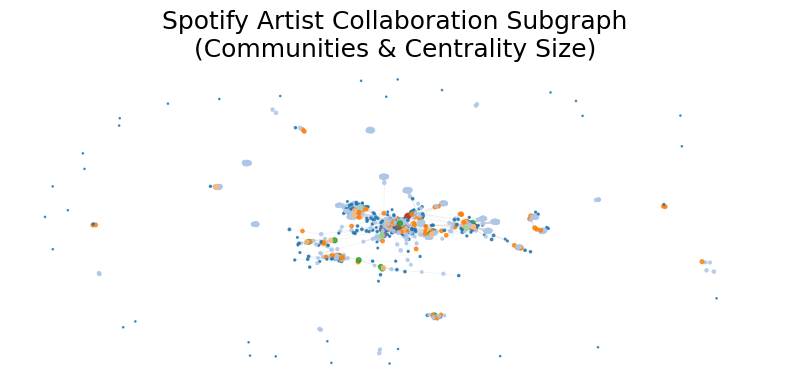

In [30]:
pos = nx.spring_layout(G_real, seed=42)
node_color = [pr_cent[node] for node in G_real.nodes()]

# PageRank values
node_size = [5000 * pr_cent[node] for node in G_real.nodes()]

plt.figure(figsize=(8, 4))

# Draw nodes
nx.draw_networkx_nodes(
    G_real,
    pos,
    node_color=node_color,         # Community colors
    node_size=node_size,           # Centrality-based sizes
    cmap=plt.cm.tab20,
    alpha=0.8
)

# Draw edges
nx.draw_networkx_edges(
    G_real,
    pos,
    edge_color='lightgray',
    width=0.3,
    alpha=0.5
)

plt.title("Spotify Artist Collaboration Subgraph\n(Communities & Centrality Size)", fontsize=18)
plt.axis('off')
plt.tight_layout()
plt.show()

The second part of the code uses link prediction algorithms to identify potential future collaborations. It starts by selecting random pairs of artists who have not yet worked together. Then, it calculates how likely each pair is to collaborate in the future using two methods: the Jaccard Coefficient and the Adamic-Adar Index. These methods score pairs based on how many mutual collaborators they have, with slight differences in how the scores are weighted. The result is a list of the top 10 artist pairs that are most likely to collaborate next, based on their position in the network. This analysis is useful for uncovering hidden opportunities for collaboration and can support recommendations or industry insights.

Together, the code provides both a visual and analytical look into the Spotify artist network—helping us understand the current structure while also predicting how it might grow in the future.

In [31]:
# Step 1: Get top non-connected pairs to predict on
# Sample only from a subset of node pairs to save time
non_edges = list(nx.non_edges(G_sub))
sampled_non_edges = random.sample(non_edges, min(10000, len(non_edges)))  # 10k samples

# Step 2: Compute link prediction scores

# Jaccard Coefficient
jaccard_preds = list(jaccard_coefficient(G_sub, sampled_non_edges))
top_jaccard = sorted(jaccard_preds, key=lambda x: x[2], reverse=True)[:10]

# Adamic-Adar Index
adamic_preds = list(adamic_adar_index(G_sub, sampled_non_edges))
top_adamic = sorted(adamic_preds, key=lambda x: x[2], reverse=True)[:10]

# Step 3: Display results
print("Top 10 Jaccard Predictions (Node A, Node B, Score):")
for u, v, p in top_jaccard:
    print(f"{u} ↔ {v} | Score: {p:.4f}")

print("\nTop 10 Adamic-Adar Predictions (Node A, Node B, Score):")
for u, v, p in top_adamic:
    print(f"{u} ↔ {v} | Score: {p:.4f}")

Top 10 Jaccard Predictions (Node A, Node B, Score):
yaeow ↔ snøw | Score: 0.7500
specimen a ↔ ed solo | Score: 0.3750
ibringdalulz ↔ khantrast | Score: 0.3529
mc rick ↔ mc kadu | Score: 0.3333
mc ig ↔ love funk | Score: 0.2941
turma do pagode ↔ di propósito | Score: 0.2727
pedro lotto ↔ mc marks | Score: 0.2727
brian may ↔ antonio carmona | Score: 0.2619
alejandro lerner ↔ jesse & joy | Score: 0.2619
alejandro lerner ↔ antonio carmona | Score: 0.2619

Top 10 Adamic-Adar Predictions (Node A, Node B, Score):
ana mena ↔ shakira | Score: 3.9533
mc ig ↔ love funk | Score: 3.4344
neha kakkar ↔ vishal dadlani | Score: 3.3639
giuseppe verdi ↔ gioachino rossini | Score: 3.2322
rashmi virag ↔ neha kakkar | Score: 3.0982
brian may ↔ antonio carmona | Score: 2.8889
alejandro lerner ↔ jesse & joy | Score: 2.8889
jesse & joy ↔ melendi | Score: 2.8889
alejandro lerner ↔ antonio carmona | Score: 2.8889
mc rick ↔ mc kadu | Score: 2.8687


## 6. Co-occurrences
In this part we count how often pairs of the most common words appear together in the same song title. It goes through each title, checks which of the top words are present, and increases a count for each pair that co-occurs. This information is later used to build a graph showing how the top words are related based on co-occurrences.

In [32]:
df = pd.read_csv('dataset.csv')

# Combine all track names into one long string
all_track_names = ' '.join(df['track_name'].dropna().astype(str)).lower()

# Use regex to extract words
words = re.findall(r'\b\w+\b', all_track_names)

# Count word frequencies
word_counts = Counter(words)

# Get the 20 most common words
top_20 = word_counts.most_common(20)

print("Top 20 most frequent words in track names:")
for i, (word, freq) in enumerate(top_20, 1):
    print(f"{i}. {word} ({freq} times)")

Top 20 most frequent words in track names:
1. the (9498 times)
2. you (4674 times)
3. i (4382 times)
4. a (3889 times)
5. me (3772 times)
6. of (3606 times)
7. in (3188 times)
8. vivo (3159 times)
9. remix (2991 times)
10. ao (2882 times)
11. de (2682 times)
12. feat (2612 times)
13. love (2521 times)
14. to (2440 times)
15. s (2309 times)
16. it (2252 times)
17. my (2029 times)
18. no (1979 times)
19. christmas (1926 times)
20. from (1856 times)


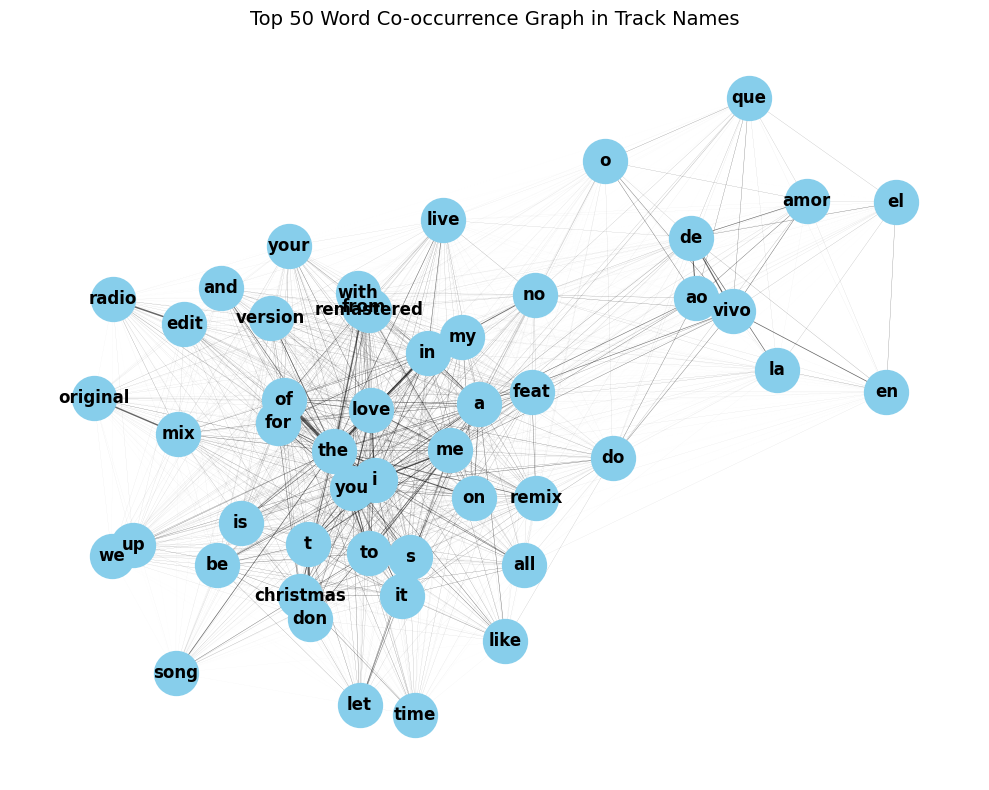

In [33]:
# Preprocess and tokenize track names
track_names = df['track_name'].dropna().astype(str).str.lower()
tokenized_tracks = [re.findall(r'\b\w+\b', name) for name in track_names]

# Count all word frequencies
word_counts = Counter(word for track in tokenized_tracks for word in track)

# Get top 50 most frequent words
top_words = [word for word, _ in word_counts.most_common(50)]

# Initialize co-occurrence matrix
co_occurrence = defaultdict(lambda: defaultdict(int))

# Count co-occurrences of top words
for track in tokenized_tracks:
    words_in_track = set(track)
    for word1 in top_words:
        if word1 in words_in_track:
            for word2 in top_words:
                if word2 != word1 and word2 in words_in_track:
                    co_occurrence[word1][word2] += 1

# Build the graph
G = nx.Graph()

# Add nodes
for word in top_words:
    G.add_node(word)

# Add edges with weights
for word1 in co_occurrence:
    for word2 in co_occurrence[word1]:
        weight = co_occurrence[word1][word2]
        if weight > 0:
            G.add_edge(word1, word2, weight=weight)

# Draw the graph
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, seed=50)  # Layout for aesthetics

# Draw nodes and edges with weights
edges = G.edges(data=True)
weights = [d['weight'] for (u, v, d) in edges]
nx.draw_networkx_nodes(G, pos, node_size=1000, node_color='skyblue')
nx.draw_networkx_edges(G, pos, width=[w / max(weights) * 5 for w in weights], alpha=0.6)
nx.draw_networkx_labels(G, pos, font_size=12, font_weight='bold')

# Show plot
plt.title("Top 50 Word Co-occurrence Graph in Track Names", fontsize=14)
plt.axis('off')
plt.tight_layout()
plt.show()

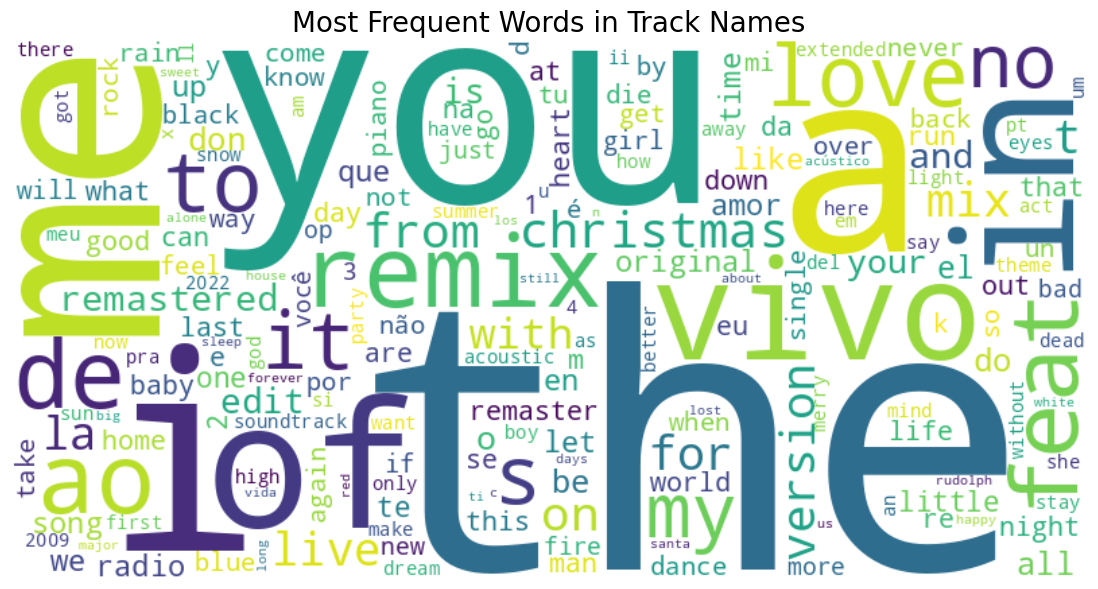

In [34]:
# Flatten the list of tokenized words from track names
all_words = [word for track in tokenized_tracks for word in track]

# Count word frequencies
word_freq = Counter(all_words)

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate_from_frequencies(word_freq)

plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Most Frequent Words in Track Names", fontsize=20)
plt.show()

## Conclusion

The analysis of the Spotify artist collaboration network revealed key patterns in how artists connect and collaborate. By constructing a graph from pre-processed data, we identified influential artists through centrality measures and uncovered genre-based communities using the Louvain algorithm on a top 1000-node subgraph. Analysis of assortativity and homophily on a larger subgraph (10,000 nodes) showed strong genre-based collaboration and a divide between artists with and without explicit content. We also compared the real network to synthetic models, predicted likely future collaborations, and examined lyrical themes through word co-occurrence analysis. These insights informed the development of a social referral system that suggests potential collaborators based on network structure, genre similarity, and other factors.

Future directions include building a model to predict collaborations using artist and network features, studying how genres evolve through collaborations, or linking an artist's position in the network to their commercial success. Deeper exploration of specific communities and further tuning of the recommendation system could provide even more personalized and accurate suggestions.